# VGG论文复现

## ⭐ VGG的主要特点
1. **结构简单：**

全部使用3×3卷积核，步幅为1，填充为1，保持特征图大小不变。

2×2最大池化层，步幅为2，用于下采样。

2. **深层网络：**

通过堆叠多个卷积层来增加深度，从而提升模型的表达能力。

例如，VGG16 的架构为：
```css
[Conv3-64] ×2 → MaxPool → [Conv3-128] ×2 → MaxPool → 
[Conv3-256] ×3 → MaxPool → [Conv3-512] ×3 → MaxPool → 
[Conv3-512] ×3 → MaxPool → FC-4096 → FC-4096 → FC-1000 → Softmax
```
3. **全连接层：**

在卷积层之后，VGG使用全连接层（FC层）进行分类。

VGG16和VGG19都使用两个4096维的全连接层和一个1000维的输出层（对应ImageNet 1000类）。

4. **权重可迁移：**

VGG模型在ImageNet上的预训练权重常用于迁移学习，在许多计算机视觉任务（如目标检测、语义分割）中表现优异。

## ⚡ VGG的优势与劣势
1. **✅ 优点：**

架构统一且易于理解。

性能优异，尤其在ImageNet图像分类挑战赛中取得了优异成绩。

2.**❌ 缺点：**

参数量巨大（VGG16约有138M参数），导致存储和推理成本高。

计算复杂度高，不适用于资源受限的设备。

如果你在研究扩散模型，VGG有时也用作特征提取器来计算感知损失（perceptual loss），因为它在捕捉图像语义特征方面表现很好。

## ⚙️ VGG的架构
<img src="img/VGG架构.png">

## VGG的代码实现
由于VGG的网络结构比较复杂，我们通过分析VGG结构后会发现它实际上是由许多类似的“VGG块”构成，每一个“VGG块”的实现则相对比较简单。最后使用nn.Sequential()函数将这些“VGG块”串联起来，就可以得到完整的VGG网络。

下面我们来实现VGG网络的构建。此处的数据库是ImageNet,我们同样采用tiny-imagenet数据集。（同AlexNet）


### 1. 必要库的导入

In [2]:
import os
import sys
import torch
from PIL import Image
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 获取当前文件的父目录
parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'),'..'))
# 如果父目录不在 sys.path中，则添加
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
import utils
    
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.mps.is_available()
                      else 'cpu')
print(torch.__version__)
print(device)

2.6.0
mps


### 2.导入数据库并转换为DataLoader格式

在这一部分中，我们使用torchvision.transforms 仿照原论文对图像进行预处理：
- `Resize` 和 `CenterCrop`：调整图像大小以匹配模型输入。
- `ToTensor`：将图像转换为张量。
- `Normalize`：对像素值进行归一化，有助于模型更快收敛。
- 在训练集中用 `RandomHorizontalFlip`使得图像随机水平翻转，增强图像

⚠️ **初学者提示**：
- 确保 `mean` 和 `std` 值与预训练模型使用的值一致。
- 输入图像的大小应与模型期望的输入大小匹配。

In [2]:
# VGG原论文的预处理流程
transform = {
    'train':transforms.Compose([
    transforms.Resize(256),                      # 缩放最短边为256像素
    transforms.RandomCrop(224),                  # 中心裁剪224x224
    transforms.RandomHorizontalFlip(p=0.5),      # 以50%概率水平翻转
    transforms.ToTensor(),                       # 转换为Tensor并缩放到[0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 按ImageNet均值和标准差归一化
                         std=[0.229, 0.224, 0.225])]),
    'val':transforms.Compose([
    transforms.Resize(256),                      # 缩放最短边为256像素
    transforms.CenterCrop(224),                  # 中心裁剪224x224
    transforms.ToTensor(),                       # 转换为Tensor并缩放到[0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 按ImageNet均值和标准差归一化
                         std=[0.229, 0.224, 0.225])
    ])}

In [3]:
# 读取验证集的标签
val_labels = {}
with open('../Datasets/tiny-imagenet-200/val/val_annotations.txt') as f:
    for line in f:
        parts = line.strip().split('\t')
        filename, label = parts[0], parts[1]
        val_labels[filename] = label
print(val_labels['val_0.JPEG'])

n03444034


In [4]:
# 首先将训练数据集加载到DataLoader中
ImageNet_train = datasets.ImageFolder(root='../Datasets/tiny-imagenet-200/train',transform=transform['train'])
ImageNet_train_iter = DataLoader(ImageNet_train,batch_size=64,shuffle=True,num_workers=0)

# 自定义验证集数据集
class TinyImageNetValDataset(Dataset):
    def __init__(self, img_dir, val_labels, transform=None):
        self.img_dir = img_dir
        self.img_dict = val_labels
        self.transform = transform
        self.classes = sorted(list(set(self.img_dict.values())))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.img_list = list(self.img_dict.keys())

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[self.img_dict[img_name]]

        if self.transform:
            image = self.transform(image)
        return image, label
    
ImageNet_val = TinyImageNetValDataset(
    img_dir='../Datasets/tiny-imagenet-200/val/images',
    val_labels=val_labels,
    transform=transform['val'])
ImageNet_val_iter = DataLoader(ImageNet_val, batch_size=64, shuffle=False, num_workers=0)

In [5]:
# 尝试输出两个DataLoader中的第一批张量的形状
img_train = next(iter(ImageNet_train_iter))
print(len(img_train))
print(img_train[0].shape)
print(img_train[1].shape)
print(img_train[1])

img_val = next(iter(ImageNet_val_iter))
print(len(img_val))
print(img_val[0].shape)
print(img_val[1].shape)
print(img_val[1])

2
torch.Size([64, 3, 224, 224])
torch.Size([64])
tensor([178, 141, 140, 109, 119,  64,  18, 112,  73, 137, 187,  53, 117, 161,
         13,  21, 155,  27, 160, 195,  89,  51, 177,  16, 133, 122,  45,  49,
        183, 115, 152,  22, 160,  28, 183, 103,  63, 176, 187, 165,  75, 110,
         87,  50, 161, 145,  45, 115, 186,  14, 174, 101,  63,  96, 189, 172,
        144,  39,  25, 139, 199,  23,  29, 121])
2
torch.Size([64, 3, 224, 224])
torch.Size([64])
tensor([107, 139, 140,  69,  69, 161, 147,  73, 145,  39, 158, 188,  39, 120,
         21,  79,  33, 165, 153, 119, 123, 124,  18,   1, 170, 141, 171, 158,
         79,  25, 121, 179, 124, 130, 176,  86,   6, 129, 142, 127,  33,  33,
         44,  40, 110,  40, 159, 184,  57,  80,   9,  34,  39,  14,  75, 199,
         10,  99,  66, 160,  69, 177,  25, 101])


### 3. 定义VGG块
#### 🔎 VGG块的构建规律

1. **卷积层：** 每个VGG块包含2到3个连续的卷积层，每个卷积层使用：
- 卷积核大小：3×3
- 步幅（stride）：1
- 填充（padding）：1（保持特征图大小不变）

2. **激活函数：** 每个卷积层后面跟一个ReLU激活。

3. **通道数：** 随着网络深度的增加，每个块的输出通道数量依次为：
```css
64 → 128 → 256 → 512 → 512
```
4. **池化层：** 每个VGG块后面接一个2×2最大池化层，步幅为2，用于特征下采样。

#### 🏗️ VGG不同架构的VGG块配置
| 网络结构   | Block1        | Block2        | Block3          | Block4          | Block5          |
|------------|----------------|----------------|------------------|------------------|------------------|
| **VGG11**  | 1×Conv64       | 1×Conv128      | 2×Conv256        | 2×Conv512        | 2×Conv512        |
| **VGG13**  | 2×Conv64       | 2×Conv128      | 2×Conv256        | 2×Conv512        | 2×Conv512        |
| **VGG16**  | 2×Conv64       | 2×Conv128      | 3×Conv256        | 3×Conv512        | 3×Conv512        |
| **VGG19**  | 2×Conv64       | 2×Conv128      | 4×Conv256        | 4×Conv512        | 4×Conv512        |



In [3]:
def vgg_block(num_convs,in_channels,out_channels):
    """
    构建VGG块:多个3*3卷积层 + ReLU激活 + 2*2最大池化。
    
    Args:
        num_convs (int): 卷积层数量
        in_channels (int): 输入通道数
        out_channels (int): 输出通道数
    
    Returns:
        nn.Sequential: VGG块
    """
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1))
        layers.append(nn.ReLU(inplace=True))
        in_channels = out_channels
    layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

### 4. 搭建VGG神经网络模型
实际上我们完全可以定义一个比较通用的VGG模型，通过不同的参数输入可以构建不同深度和广度的VGG神经网络

In [4]:
class VGG(nn.Module):
    def __init__(self,conv_arch,fc_features=4096,fc_hidden_units=4096,num_classes=1000):
        """
        构建完整的VGG网络。
        
        Args:
            conv_arch (list): VGG卷积部分的配置,每个元素为 (卷积层数, 输入通道, 输出通道)
            fc_features (int): 第一个全连接层的输入特征数
            fc_hidden_units (int): 隐藏层的神经元数
            num_classes (int): 分类类别数
        """
        super(VGG,self).__init__()
        
        # 计算全连接层输入的特征数 (根据卷积层输出的尺寸)
        self.fc_features = fc_features  # 自定义输入特征数量，可以根据卷积输出尺寸来计算
        self.fc_hidden_units = fc_hidden_units
        self.num_classes = num_classes
        
        self.features = self.make_layers(conv_arch)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_features,fc_hidden_units),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(fc_hidden_units, fc_hidden_units),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(fc_hidden_units, num_classes)
        )

    def make_layers(self,conv_arch):
        layers=[]
        for (num_convs,in_channels,out_channels) in conv_arch:
            layers.append(vgg_block(num_convs,in_channels,out_channels))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x
net = VGG([(1, 3, 64), (1, 64, 128), (2, 128, 256), (2, 256, 512), (2, 512, 512)], fc_features=512*7*7).to(device)
print(net)

VGG(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), paddi

In [6]:
# 📚 VGG不同架构的配置 (命名的来源是卷积层数+全连接层数)
vgg11_arch = [(1, 3, 64), (1, 64, 128), (2, 128, 256), (2, 256, 512), (2, 512, 512)]
vgg13_arch = [(2, 3, 64), (2, 64, 128), (2, 128, 256), (2, 256, 512), (2, 512, 512)]
vgg16_arch = [(2, 3, 64), (2, 64, 128), (3, 128, 256), (3, 256, 512), (3, 512, 512)]
vgg19_arch = [(2, 3, 64), (2, 64, 128), (4, 128, 256), (4, 256, 512), (4, 512, 512)]

In [7]:
# 🏃‍♂️ **测试不同VGG模型**
def test_vgg(arch, name):
    model = VGG(arch,fc_features=512*7*7)
    X = torch.randn(1, 3, 224, 224)  # 模拟输入
    output = model(X)
    print(f"{name} 输出形状: {output.shape}")  # 期望输出: torch.Size([1, 1000])



test_vgg(vgg11_arch, "VGG11")
test_vgg(vgg13_arch, "VGG13")
test_vgg(vgg16_arch, "VGG16")
test_vgg(vgg19_arch, "VGG19")

VGG11 输出形状: torch.Size([1, 1000])
VGG13 输出形状: torch.Size([1, 1000])
VGG16 输出形状: torch.Size([1, 1000])
VGG19 输出形状: torch.Size([1, 1000])


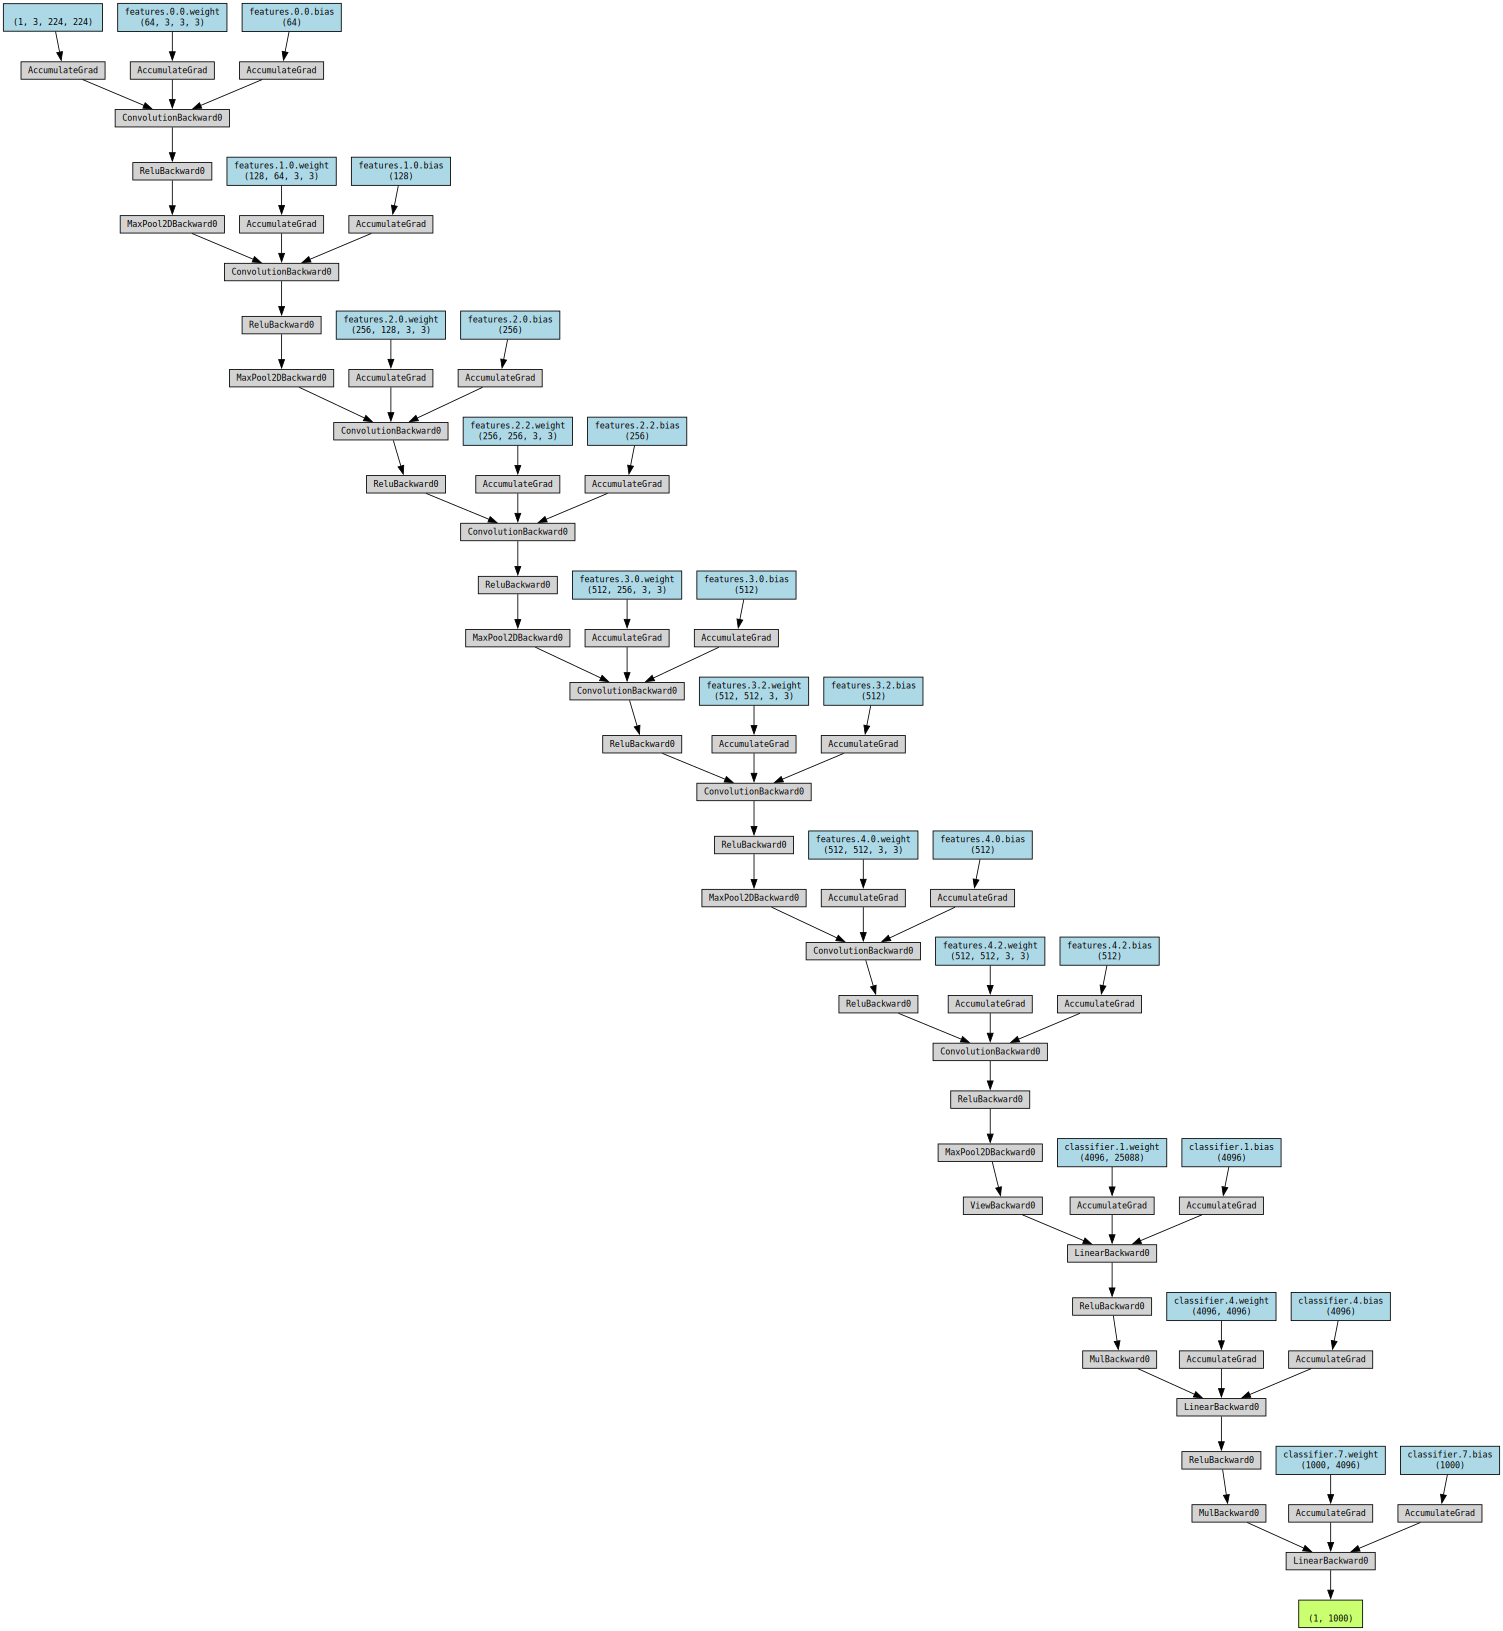

In [8]:
from torchviz import make_dot
import os
os.environ["PATH"] += os.pathsep + '/opt/homebrew/bin'  # M1/M2 Mac
model = net.to(device)
x = torch.rand(1, 3, 224, 224).to(device).requires_grad_(True)
y = model(x)
MyConvNetVis = make_dot(y, params=dict(model.named_parameters()))
MyConvNetVis.format = "png"
MyConvNetVis.render("VGG", format="png")
MyConvNetVis

### 5. 用VGG11来训练！

In [10]:
'''
net = VGG(vgg11_arch,fc_features=512*7*7,num_classes=200).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(),lr=0.001)
utils.training_loop(net,loss_fn=loss_fn,optimizer=optimizer,train_iter=ImageNet_train_iter,test_iter=ImageNet_val_iter,epochs=15,device=device)
'''

'\nnet = VGG(vgg11_arch,fc_features=512*7*7,num_classes=200).to(device)\nloss_fn = nn.CrossEntropyLoss()\noptimizer = optim.Adam(params=net.parameters(),lr=0.001)\nutils.training_loop(net,loss_fn=loss_fn,optimizer=optimizer,train_iter=ImageNet_train_iter,test_iter=ImageNet_val_iter,epochs=15,device=device)\n'